In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torchdiffeq
import torch
import matplotlib.pyplot as plt

import dismech_nn

c:\Users\12345\Documents\Dev\dismech_nn\dismech_nn\train.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
rod_r = 0.001
rod_l = 0.1
E = 1e9

rho_metal = 7000
rho_fluid = 1000

r = torch.tensor([0.005, 0.025, 0.005], dtype=torch.float64)

eta = 1000


def get_sphere_mass(r, rho):
    return 4/3 * torch.pi * r ** 3 * rho


def get_gravity(r, rho_diff):
    return 4/3 * torch.pi * r ** 3 * rho_diff * 9.81


def get_viscous(r, eta):
    return -(6 * torch.pi * eta * r), -(6 * torch.pi * eta * r)


ms = get_sphere_mass(r, rho_metal)
g = get_gravity(r, rho_metal - rho_fluid)

a = dismech_nn.DiscreteElasticRod2D(rod_l, rod_r, E, ms)

a.add_constant_force(torch.zeros(len(r)), -g)    # gravity only in Y

a.add_velocity_proportional_force(*get_viscous(r, eta))

In [4]:
# Run the profiler
a.run_forward_profile()

----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                        bend        27.42%      28.737ms        54.45%      57.058ms     570.578us           100  
                     stretch        13.87%      14.539ms        27.72%      29.050ms     290.504us           100  
                 aten::slice         7.99%       8.369ms         9.16%       9.603ms       4.573us          2100  
                      linear         4.92%       5.153ms         8.71%       9.127ms      91.270us           100  
                   aten::sub         3.05%       3.201ms         5.62%       5.886ms       7.357us           800  
                    aten::to         1.15%       1.200ms         5.15%       5.4

In [10]:
t = torch.linspace(0, 10, 1000)
y0s = torch.stack([a.at_rest()])
                 #a.at_rest() + torch.tensor([0., 0., 0., 0.01, 0., 0., 0., 0., 0., 0., 0., 0.]),
                 #a.at_rest() + torch.tensor([0., 0., 0., 0.005, 0., 0., 0., 0., 0., 0., 0., 0.]),
                 #a.at_rest() + torch.tensor([0., 0., 0., -0.01, 0., 0., 0., 0., 0., 0., 0., 0.])])

for i, y0 in enumerate(y0s):
    sol = torchdiffeq.odeint_adjoint(a, y0, t, method='euler', options={'step_size':5e-5})
    #torch.save(sol, 'example_{}.pt'.format(i))

In [21]:
t = torch.linspace(0, 10, 1000)
sol = torch.load('example_3.pt').permute(1,0)

C:\Users\12345\AppData\Local\Temp\ipykernel_21244\3637890838.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sol = torch.load('example_3.pt').permute(1,0)


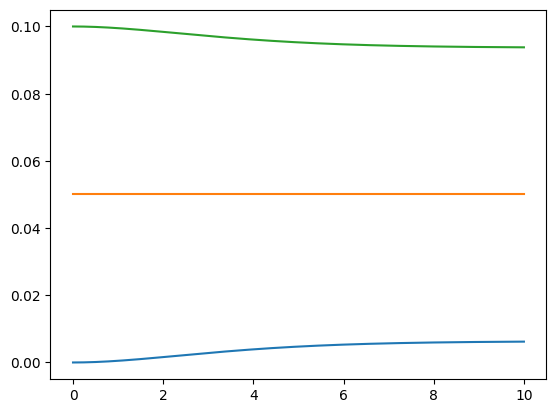

In [11]:
sol = sol.permute(1,0)
plt.plot(t, sol[0])
plt.plot(t, sol[2])
plt.plot(t, sol[4])
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


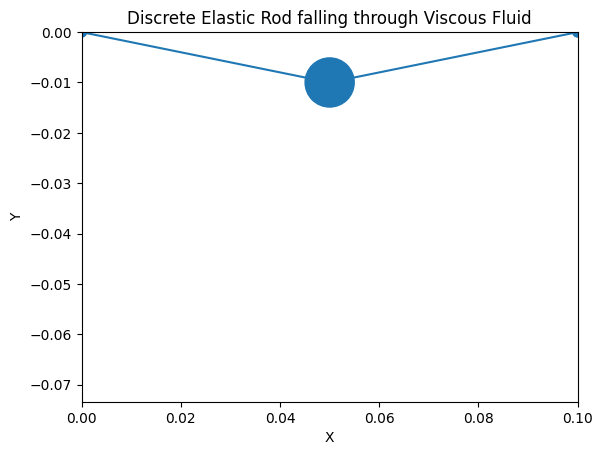

In [23]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation
from IPython.display import HTML

def get_der_animation(t, sol, r, frame_delay = 50, min_area = 10):
    time_step = int((t[1] - t[0]) * 1000)
    spf = int(frame_delay / time_step)
    N = int(len(sol) / 2)

    x_max = torch.max(sol[::2])
    x_min = torch.min(sol[::2])

    y_max = torch.max(sol[1::2])
    y_min = torch.min(sol[1::2])

    fig = plt.figure()
    ax = plt.axes(xlim=(x_min, x_max), ylim=(y_min, y_max))
    ax.set_title("Discrete Elastic Rod falling through Viscous Fluid")
    ax.set_ylabel("Y")
    ax.set_xlabel("X")

    a = torch.pi * r ** 2
    a *= 50 / torch.min(a)

    line, = ax.plot([], [])
    scatter = ax.scatter([0 for _ in range(int(len(sol) / 2))], [0 for _ in range(int(len(sol) / 2))], s=a.int(), marker='o')

    def update(frame):
        x = []
        y = []

        for node in torch.split(sol, 2):
            x.append(node[0][frame * spf])
            y.append(node[1][frame * spf])
        line.set_data(x, y)
        scatter.set_offsets(torch.stack([torch.stack(x), torch.stack(y)]).permute(1,0))
        return line,

    return animation.FuncAnimation(fig, update, frames=int(len(t) / spf), interval=frame_delay)

ani = get_der_animation(t, sol[:int(len(sol)/2)], r)
ani.save('der2.gif')